In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import scipy.stats as sista
from statsmodels.stats.multitest import multipletests

np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# Experiment setup
experiment_name = 'collinearity'
data_dir = f'data/collinearity'
exp = decode_eeg.Experiment(experiment_name,data_dir,test=False,info_variable_names=['sampling_rate','times'])

In [86]:
# Classification parameters and setup
time_window = 100
time_step = 100
trial_average = 20
n_splits = 100
#0: 2 grouped, 1: 2 ungrouped, 2: 4 grouped, 3: 4 ungrouped 
group_dict = {0:[1],1:[2],2:[3]}
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=3)
clfr.classifier = LogisticRegression()

In [87]:
# If you want to retrain classifiers, run this cell. Otherwise go to next cell.

clfr.confidence_scores = np.empty((exp.nsub,len(wrangl.t),wrangl.n_splits,clfr.num_labels))
for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    
    # Reshaping data into [trials,electrodes,timepoints]
    xdata = np.moveaxis(xdata,[0,1,2],[2,0,1])
    xdata,ydata = wrangl.setup_data(xdata,ydata)

    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        
        # remove 4G from training, only train on 2U and 2G
        X_train_all = X_train_all[((y_train == 0) + (y_train == 2))]
        # test on 4G, 2U, and 4U
        y_train = y_train[((y_train == 0) + (y_train == 2))] 
        
        # shuffle labels for chance classification
        y_test_shuffle = np.random.permutation(y_test)
        
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

            X_train, X_test = clfr.standardize(X_train, X_test)
            clfr.classifier.fit(X_train, y_train)

            clfr.acc[isub,wrangl.itime,wrangl.ifold] = clfr.classifier.score(X_test,y_test)
            clfr.acc_shuff[isub,wrangl.itime,wrangl.ifold] = clfr.classifier.score(X_test,y_test_shuffle)

            # get confidence of classification for each trial bin. >0 means set size 4 is predicted.
            confidence_scores = clfr.classifier.decision_function(X_test)
            for i in set(y_test):
                clfr.confidence_scores[isub,wrangl.itime,wrangl.ifold,i] = np.mean(confidence_scores[y_test==i])

# Set up interp object and save results.
interp = decode_eeg.Interpreter(clfr, subtitle = f'colinearity_preds')
interp.confidence_scores = clfr.confidence_scores
# interp.save_results(additional_values=['confidence_scores'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [96]:
# Set up interp object and load pre-existing results. Skip if you ran previous cell.
interp = decode_eeg.Interpreter()
interp.load_results('collinearity.pickle')

In [5]:
def get_plot_line(a):
    """
    Takes in 2D array of shape [subjects,time points].
    Returns mean, and upper/lower SEM lines.
    """
    mean = np.mean(a,0)
    sem = sista.sem(a,0)
    upper,lower = mean + sem, mean - sem
    return mean, upper, lower

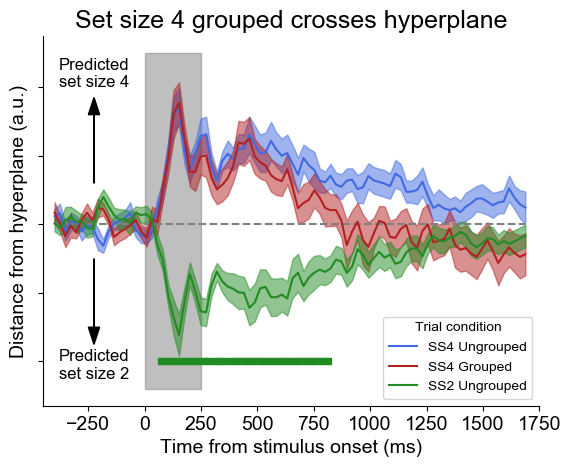

In [97]:
# Get means for each condition
ss2u = np.mean(interp.confidence_scores,2)[:,:,0]
ss4g = np.mean(interp.confidence_scores,2)[:,:,1]
ss4u = np.mean(interp.confidence_scores,2)[:,:,2]

# Plot confidence of classifier, which is proportional to distance from hyperplane.
stim_lower,stim_upper = -2.4,2.5
stim_time = [0,250]

ax = plt.subplot(111)

ax.fill_between(stim_time,[stim_lower,stim_lower],[stim_upper,stim_upper],color='gray',alpha=.5)
ax.plot(interp.t,np.zeros((len(interp.t))),'--',color='gray')
colors = ['royalblue','firebrick','forestgreen']

med, upper, lower = get_plot_line(ss4u)
ax.plot(interp.t,med,colors[0],label = 'SS4 Ungrouped')
ax.fill_between(interp.t,upper,lower, color=colors[0],alpha=.5)

med, upper, lower = get_plot_line(ss4g)
ax.plot(interp.t,med,colors[1],label = 'SS4 Grouped')
ax.fill_between(interp.t,upper,lower, color=colors[1], alpha=.5)

med, upper, lower = get_plot_line(ss2u)
ax.plot(interp.t,med,colors[2],label = 'SS2 Ungrouped')
ax.fill_between(interp.t,upper,lower, color=colors[2], alpha=.5)

plt.legend(title='Trial condition',loc='lower right')

# aesthetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.yticks(np.arange(-3,4,1),labels=['','','','','','',''])
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.xlim(-450,1750)
# plt.ylim([-4,4])

# labelling
plt.title('Set size 4 grouped crosses hyperplane',fontsize=18)
plt.xlabel('Time from stimulus onset (ms)', fontsize=14)
plt.ylabel('Distance from hyperplane (a.u.)', fontsize=14)

plt.text(-225,-2.25,'Predicted\nset size 2',fontsize=12,ha='center')
plt.text(-225,2,'Predicted\nset size 4',fontsize=12,ha='center')
plt.text(125,2.6,'Stim',fontsize=14,ha='center',c='white')
plt.arrow(-225,.6,0,1, head_width=50, head_length=.25,color='k')
plt.arrow(-225,-.5,0,-1,head_width=50, head_length=.25,color='k')

# Significance testing
p_44 = np.zeros(len(interp.t[interp.t>0]))
p_24 = np.zeros(len(interp.t[interp.t>0]))
# only test on timepoints after stimulus onset
for i,t in enumerate(np.arange(len(interp.t))[interp.t>0]):
    # one-sided paired ttest
    _,p_44[i] = sista.ttest_rel(a=ss4u[:,t],b=ss4g[:,t],alternative='greater')
    _,p_24[i] = sista.ttest_rel(a=ss2u[:,t],b=ss4g[:,t],alternative='less')

# Use Benjamini-Hochberg procedure for multiple comparisons, defaults to FDR of .05
sig05_44,corrected_p_44,_,_ = multipletests(p_44,method='fdr_bh')
sig05_24,corrected_p_24,_,_ = multipletests(p_24,method='fdr_bh')

plt.scatter(interp.t[interp.t>0][sig05_44]-10, np.ones(sum(sig05_44))*(2), 
            marker = 's', s=22, c = 'royalblue',label='p < .05')
plt.scatter(interp.t[interp.t>0][sig05_24]-10, np.ones(sum(sig05_24))*(-2), 
            marker = 's', s=22, c = 'forestgreen',label='p < .05')

# plt.savefig('output/figures/colinearity_hyperplane.png',dpi=500)
# plt.savefig('output/figures/colinearity_hyperplane.pdf',dpi=500)

plt.show()

In [100]:
import seaborn as sns
import pandas as pd

In [191]:
encoding = (interp.t>0) & (interp.t<250)
first_half = (interp.t>250) & (interp.t<1000)
second_half = (interp.t>1000)

def plot_swarm_time_period(time_idx):
    a = np.mean(ss4u[:,time_idx],1)
    b = np.mean(ss4g[:,time_idx],1)
    c = np.mean(ss2u[:,time_idx],1)

    print(sista.ttest_rel(a=b,b=c,alternative='greater'))

    # format data for seaborn
    subs = np.tile(np.arange(len(a)),3)
    condition = np.repeat(['4 Ungrouped','4 Grouped','2 Unrouped'],len(a))
    df = pd.DataFrame({'subject':subs, 'Condition':condition, 'Distance from hyperplace (a.u)':np.concatenate([a,b,c])})

    my_pal = {"4 Ungrouped": "royalblue", "4 Grouped": "firebrick", "2 Unrouped": "forestgreen"}

    sns.swarmplot(x='Condition',y='Distance from hyperplace (a.u)',data=df,color='white',alpha=.85)
    sns.violinplot(x='Condition',y='Distance from hyperplace (a.u)',data=df,inner=None,palette=my_pal)

    x1,x2 = 1,2
    y1,y2 = 3.3,3.4
    plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    plt.text(1.5,3.4,'***',fontsize=16,ha='center')

    plt.ylim([-5,4])


Ttest_relResult(statistic=4.629681397819832, pvalue=9.138426439545317e-05)


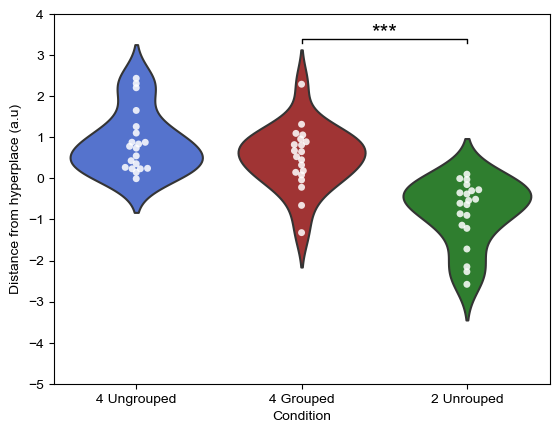

In [192]:
plot_swarm_time_period(first_half)
# plt.savefig('swarm_firsthalf.png',dpi=500)
plt.show()

In [94]:
import winsound
winsound.PlaySound("SystemExit",winsound.SND_ALIAS)